## Progetto per Data Analytics: Sarcasm Detection

### Preparazione dell'ambiente di runtime

Import delle librerie

In [1]:
import re
import string
import pandas as pd
from random import randint
import tensorflow
import nltk
from nltk import LancasterStemmer, TweetTokenizer
from nltk.corpus import stopwords
from scipy.stats import zscore
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import metrics, losses, layers, activations, models, callbacks, utils, initializers, Input
import numpy as np
from wordcloud import WordCloud

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_load_context_function'

Dowload dei file per nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Dowload del glove pre-trained vector

In [ ]:
!wget -nc http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip -n glove.42B.300d.zip

--2023-04-20 13:41:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-20 13:41:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-20 13:41:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Definizione di alcune costanti

In [ ]:
TARGET = 'sarcastic'
CONTEXT_COLS = ['author', 'subreddit', 'parent']
EMBEDDING_DIM = 300
DATA_PATH = "drive/MyDrive/Colab Notebooks/"
GLOVE_PATH = "glove.42B.300d.txt"

### Fase di import del dataset e prima analisi
In questa fase verrà importato il dataset (suddividendolo in train e validation set) e si analizzerà:
- Il numero di righe, la presenza di duplicate e di nulle
- La distribuzione del target
- La presenza di elementi del contesto ripetuti


In [ ]:
df_full = pd.read_csv(DATA_PATH + "dataset/train-balanced.tsv", sep="\t", names=[TARGET, "text", "author", "subreddit",
                                                                                 "date", "parent"]).sample(frac=0.005)
df_train, df_val = train_test_split(df_full, test_size=0.1)

df_train.index.name = "index"
print("Dimensione del dataset:\t", len(df_train), "\n")
print("tipi di variabile:\n", df_train.dtypes, "\n")
print("Prime righe di esempio:\n", df_train.head(3), "\n")
print("Righe nulle:\n", df_train.isna().sum(), "\n")
print("Righe duplicate:\n", df_train.duplicated().sum(), "\n")

Dimensione del dataset:	 4548 

tipi di variabile:
 sarcastic     int64
text         object
author       object
subreddit    object
date         object
parent       object
dtype: object 

Prime righe di esempio:
         sarcastic                                               text  \
index                                                                  
805793          0                                       Baking Soda.   
665359          1  Prepare the list of eating establishments in B...   
351691          1  Yeah, because the McCarthy Era was one of Amer...   

                 author       subreddit     date  \
index                                              
805793      sillyblanco       AskReddit  2014-08   
665359  FuckinNiceKitty  stevenuniverse  2015-06   
351691         Glostick        politics  2016-05   

                                                   parent  
index                                                      
805793  What would you include in a well stoc

Si definisce un metodo di preprocessing che:
- Rimuova le righe duplicate
- Rimuova le righe nulle (visto che sono poche non è necessario imputarle)
- Converta i tipi di variabile

In [ ]:
def dataset_opening_preprocessing(dataframe):
    """
    Funzione generata dalla prima analisi del dataframe, serve per eliminare righe nulle e duplicate e
    per effettuare le conversioni di tipo
    :param dataframe: dataframe d'input
    :type dataframe: pd.DataFrame
    :return: dataframe processato
    :rtype: pd.DataFrame
    """
    dataframe = dataframe.dropna().drop_duplicates().reindex()

    dataframe[TARGET] = dataframe[TARGET].astype("category")
    str_var = ['text', 'parent', 'subreddit', 'author']
    dataframe[str_var] = dataframe[str_var].astype("str")
    dataframe['date'] = pd.to_datetime(dataframe['date'], format="%Y-%m")
    dataframe['text'], dataframe['parent'] = dataframe['text'].str.lower(), dataframe['parent'].str.lower()
    return dataframe

In [ ]:
df_train = dataset_opening_preprocessing(df_train)
print("tipi di variabile dopo la conversione:\n", df_train.dtypes, "\n")

# Analisi del target

print("Stampa di 3 righe sarcastiche:\n", df_train.loc[df_train[TARGET] == 1].head(3)[[TARGET, 'text']], "\n")
print("Stampa di 3 righe non sarcastiche:\n", df_train.loc[df_train[TARGET] == 0].head(3)[[TARGET, 'text']], "\n\n")

print("Distribuzione del target:")
print(df_train[TARGET].value_counts(normalize=True))


tipi di variabile dopo la conversione:
 sarcastic          category
text                 object
author               object
subreddit            object
date         datetime64[ns]
parent               object
dtype: object 

Stampa di 3 righe sarcastiche:
        sarcastic                                               text
index                                                              
665359         1  prepare the list of eating establishments in b...
351691         1  yeah, because the mccarthy era was one of amer...
817783         1                                 oh yeah, no one... 

Stampa di 3 righe non sarcastiche:
        sarcastic                                               text
index                                                              
805793         0                                       baking soda.
973616         0  if by news you mean things that aren't actuall...
93217          0         thank god we finally have some solid news. 


Distribuzione del targe

### Analisi di elementi ripetuti nel contesto, utile per verificare se essi possano essere fonte d'informazione
Si definiscono, e poi applicano, due funzioni a tal proposito:

In [ ]:

def compute_proportions_series(s1, s2):
    """
    Funzione, di appoggio, che prende due serie intere con indici simili (alcuni elementi in comune, ma non tutte)
    ed effettua la proporzione della prima sull'altra
    :param s1: prima serie d'input
    :type s1: pd.Series
    :param s2: seconda serie d'input
    :type s2: pd.Series
    :return: Dataframe risultate contente le proporzioni e il numero totale di elementi
    :rtype: pd.DataFrame
    """

    s1_r = s1.reindex(s1.index.join(s2.index, how="outer"), fill_value=0)
    s2_r = s2.reindex(s1.index.join(s2.index, how="outer"), fill_value=0)

    df_out = pd.DataFrame(columns=['proportion', 'tot'], index=s1_r.index)
    df_out['tot'] = s1_r + s2_r
    df_out['proportion'] = s1_r / df_out['tot']

    return df_out


def compute_sarcastic_unique_stats(dataframe, thresholds):
    """
    Funzione che calcola per ogni elemento del contesto il value_counts sarcastico e non.
    Calcola inoltre il numero di elementi unici che superano delle soglie di sarcasmo,
    e restituisce anche le loro proporzioni

    :param dataframe: dataframe di elaborazione
    :type dataframe: pd.DataFrame
    :param thresholds: soglie in cui calcolare il numero di elementi unici sarcastici
    :type thresholds: list
    :return: sarcastic_vc, no_sarcastic_vc, sarcastic_proportions, sarcastic_unique_stats
    :rtype: (pd.Series, pd.Series, pd.Series, pd.DataFrame)
    """

    dataframe_s = dataframe.loc[dataframe[TARGET] == 1]
    dataframe_ns = dataframe.loc[dataframe[TARGET] == 0]

    sarcastic_vc = pd.Series(data=[dataframe_s[col].value_counts() for col in CONTEXT_COLS], index=CONTEXT_COLS)
    no_sarcastic_vc = pd.Series(data=[dataframe_ns[col].value_counts() for col in CONTEXT_COLS], index=CONTEXT_COLS)
    sarcastic_proportions = pd.Series(index=CONTEXT_COLS, dtype="object")

    unique_stats = pd.DataFrame(columns=CONTEXT_COLS, index=thresholds)

    tot = dataframe[CONTEXT_COLS].nunique()

    for col in CONTEXT_COLS:
        proportions = compute_proportions_series(sarcastic_vc[col], no_sarcastic_vc[col])
        sarcastic_proportions[col] = proportions.sort_values(by='proportion', ascending=False)

        unique_stats[col] = unique_stats[col].to_frame().apply(
            lambda row: (proportions['proportion'] >= row.name / 100).sum(), axis="columns")

    unique_stats.loc['tot unique'] = tot

    return sarcastic_vc, no_sarcastic_vc, sarcastic_proportions, unique_stats

In [ ]:
df_s_vc, df_ns_vc, s_prop, df_unique_stats = compute_sarcastic_unique_stats(df_train, [100, 75, 50, 25])

print("\n\n\nAnalisi del numero di subreddit, autori e parent unici:\n", df_unique_stats, "\n")
print("In percentuale:\n", df_unique_stats * 100 / len(df_train), "\n")
print("In percentuale rispetto alla categoria:\n", df_unique_stats.iloc[:-1] * 100 / df_unique_stats.iloc[-1], "\n")




Analisi del numero di subreddit, autori e parent unici:
             author  subreddit  parent
100           2164        333    2226
75            2166        366    2226
50            2212        548    2226
25            2212        660    2226
tot unique    4452       1117    4543 

In percentuale:
                author  subreddit     parent
100         47.591819   7.323510  48.955355
75          47.635804   8.049263  48.955355
50          48.647460  12.051902  48.955355
25          48.647460  14.515065  48.955355
tot unique  97.910710  24.565648  99.912030 

In percentuale rispetto alla categoria:
         author  subreddit     parent
100  48.607367  29.811996  48.998459
75   48.652291  32.766338  48.998459
50   49.685535  49.059982  48.998459
25   49.685535  59.086840  48.998459 



Si individua la presenza di elementi duplicati nel contesto, principalmente per la feature 'subreddit'.
Si procede dunque con un'approfondimento su essa

Proporzioni e num post di subreddit con numero di post > di 1:
                    proportion  tot
Marijuana                1.00    2
southafrica              1.00    3
MonsterHunter            1.00    2
bodybuilding             1.00    5
NBA2k                    1.00    3
...                       ...  ...
DC_Cinematic             0.75    4
lewronggeneration        0.75    4
newzealand               0.75    4
DCcomics                 0.75    4
bicycling                0.75    4

[93 rows x 2 columns] 
gli outliers sono:
              proportion  tot
Philippines    0.909091   11
canada         0.866667   15
formula1       0.833333   12 



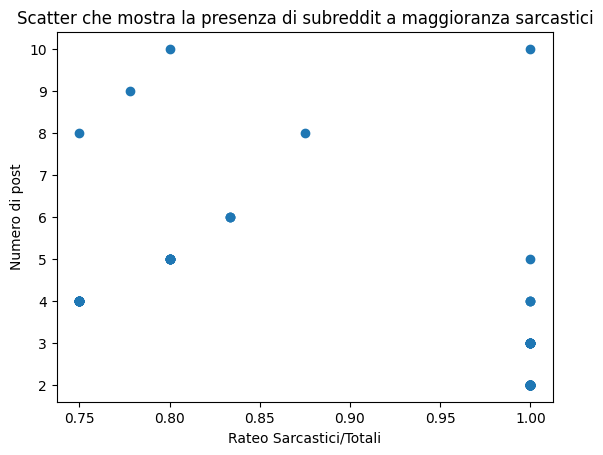

In [ ]:
subreddit_s_prop = s_prop['subreddit'].loc[s_prop['subreddit']['proportion'] >= 0.75]
# si considerano i subreddit con più di un post e si eliminano gli outlier per maggiore chiarezza
subreddit_s_prop = subreddit_s_prop.loc[subreddit_s_prop['tot'] > 1]
subreddit_s_prop_outliers = subreddit_s_prop.loc[abs(zscore(subreddit_s_prop['tot'])) >= 3]
subreddit_s_prop = subreddit_s_prop.loc[abs(zscore(subreddit_s_prop['tot'])) < 3]
print("Proporzioni e num post di subreddit con numero di post > di 1:\n", subreddit_s_prop,
      "\ngli outliers sono:\n", subreddit_s_prop_outliers, "\n")
plt.scatter(subreddit_s_prop['proportion'], subreddit_s_prop['tot'])
plt.title("Scatter che mostra la presenza di subreddit a maggioranza sarcastici")
plt.xlabel("Rateo Sarcastici/Totali")
plt.ylabel("Numero di post")
plt.show()

## Fase di analisi del testo
In questa fase si analizza il testo del commento (quindi la feature 'text').
Verranno analizzati i token di cui esso si compone, e come la frequenza di essi varia nelle fasi di:
- Eliminazione della punteggiatura;
- Eliminazione delle stopwords;
- Stemming.

Producendo tre tipi di testo:
- nsw: senza stopwords;
- nsw_st: senza stopwords e con stemming;
- st: con stemming.
che verranno poi confrontati nella successiva analisi

Si definiscono due funzioni generiche a tal proposito:

In [ ]:
def values_count_from_list(series, normalize=False):
    """
    Funzione che prende una serie che contiene liste, e restituisce gli elementi più comuni
    :param series: serie d'input
    :type series: pd.Series
    :param normalize: parametro per attivare la normalizzazione
    :type normalize: bool
    :return: Serie di value count
    :rtype: pd.Series
    """

    series_exploded = series.explode()
    return round(series_exploded.value_counts(normalize=normalize), 5)


def print_plot_most_common_token(series, num_print=10, num_plot=20,
                                 text_print="Frequenza nel testo dei token più comuni:",
                                 title_plot="Frequenza nel testo dei token più comuni"):
    """
    Funzione che stampa e plotta i token più comuni in una serie contente i token
    :param series: serie d'input
    :type series: pd.Series
    :param num_print: numero di token da stampare
    :type num_print: int
    :param num_plot: numero di token da usare nei plot
    :type num_plot: int
    :param text_print: testo da stampare a schermo
    :type text_print: str
    :param title_plot: titolo del plot
    :type title_plot: str
    :return: serie dei token più comune
    :rtype pd.Series
    """
    common_tokens = values_count_from_list(series, normalize=True)
    print("\n", text_print, "\n", common_tokens.head(num_print), "\n\n")
    fig, ax = plt.subplots()
    (common_tokens.head(num_plot) * 100).plot(kind='bar', title=title_plot, xlabel="Token", ylabel="Frequenza %")
    fig, ax = plt.subplots()
    plt.imshow(WordCloud(width=1600, height=800,
                         background_color="black").generate_from_frequencies(dict(common_tokens.to_dict())),
               interpolation='antialiased')

Si procede con la tokenizzazione del testo

stampa di tre frasi con i relativi token:
                                                      text  \
index                                                       
805793                                       baking soda.   
665359  prepare the list of eating establishments in b...   
351691  yeah, because the mccarthy era was one of amer...   

                                           text_tokenized  
index                                                      
805793                                  [baking, soda, .]  
665359  [prepare, the, list, of, eating, establishment...  
351691  [yeah, ,, because, the, mccarthy, era, was, on...   



 Frequenza nel testo dei token più comuni: 
 .      0.03457
the    0.03426
,      0.03365
to     0.02019
a      0.02019
i      0.01639
you    0.01440
and    0.01423
of     0.01298
is     0.01273
Name: text_tokenized, dtype: float64 




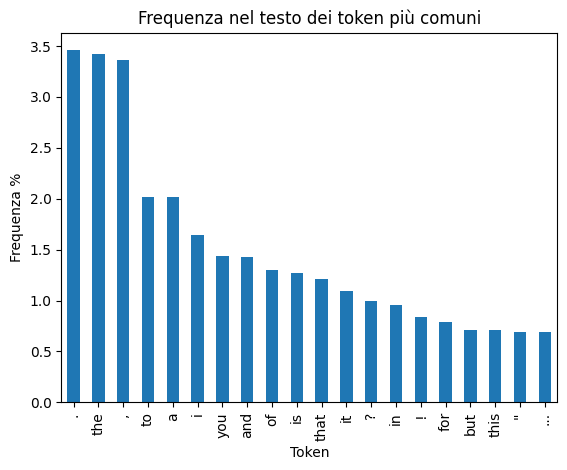

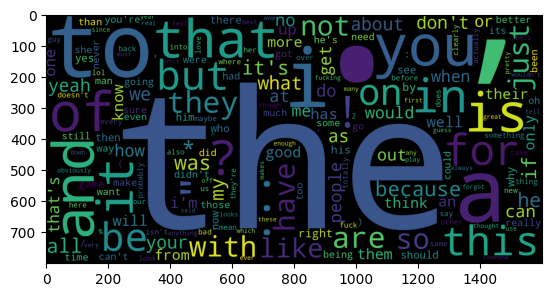

In [ ]:
tweet_tokenizer = TweetTokenizer()

df_train['text_tokenized'] = df_train['text'].apply(lambda x: tweet_tokenizer.tokenize(x))
print("stampa di tre frasi con i relativi token:\n", df_train[['text', 'text_tokenized']].head(3), "\n\n")
print_plot_most_common_token(df_train['text_tokenized'])
plt.show()

Prima di eliminare la punteggiatura, si esamina la frequenza dei simboli in frasi sarcastiche e non, in quanto essi possono essere fonte d'informazione.

Frequenza della punteggiatura in frasi sarcastiche:
      sarcastic  non_sarcastic   rateo
=     0.179614       0.043103  4.1670
!    14.279300       5.732759  2.4908
~     0.179614       0.086207  2.0835
...   8.666367       6.206897  1.3962
&     0.269421       0.215517  1.2501
'    34.665469      28.663793  1.2094
,    33.183655      28.189655  1.1772
#     0.404131       0.344828  1.1720
-     3.951504       3.405172  1.1604
]     0.404131       0.387931  1.0418
\     0.089807       0.086207  1.0418
[     0.404131       0.387931  1.0418
@     0.044903       0.043103  1.0418
*     2.245173       2.284483  0.9828
%     0.808262       0.862069  0.9376
?    11.046251      12.844828  0.8600
$     0.359228       0.431034  0.8334
.    42.164347      53.275862  0.7914
^     0.224517       0.301724  0.7441
/     1.571621       2.284483  0.6880
;     0.718455       1.120690  0.6411
:     1.930849       3.017241  0.6399
+     0.224517       0.387931  0.5788
"     2.739111       4.870690  0.56

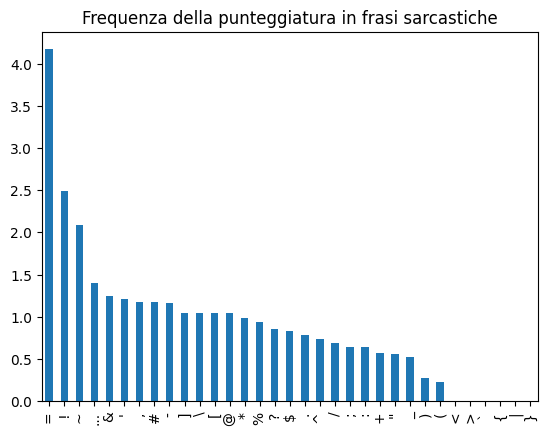

In [ ]:
all_punctuation = list(string.punctuation)
all_punctuation.append("...")
punctuation_freq = pd.DataFrame(columns=["sarcastic", "non_sarcastic"], index=all_punctuation, dtype="float64")
punctuation_freq['sarcastic'] = punctuation_freq.apply(
    lambda x: df_train.loc[df_train[TARGET] == 1, 'text'].str.contains(re.escape(x.name)).sum(), axis="columns")
punctuation_freq['non_sarcastic'] = punctuation_freq.apply(
    lambda x: df_train.loc[df_train[TARGET] == 0, 'text'].str.contains(re.escape(x.name)).sum(), axis="columns")
punctuation_freq['sarcastic'] = punctuation_freq['sarcastic'] * 100 / (df_train[TARGET] == 1).sum()
punctuation_freq['non_sarcastic'] = punctuation_freq['non_sarcastic'] * 100 / (df_train[TARGET] == 0).sum()
punctuation_freq['rateo'] = round(punctuation_freq['sarcastic'] / punctuation_freq['non_sarcastic'], 4).fillna(0)
punctuation_freq = punctuation_freq.sort_values(by='rateo', ascending=False)

print("Frequenza della punteggiatura in frasi sarcastiche:\n", punctuation_freq, "\n\n")
plt.subplots()
punctuation_freq['rateo'].plot(kind='bar', title="Frequenza della punteggiatura in frasi sarcastiche")
plt.show()

Vista la distribuzione del rateo dei simboli, si decide di mantenere quelli che sono degli outliers alla distribuzione (perchè possono discriminare meglio una frase sarcastica o non)

I punti mantenuti sono:	 ['=']

 Dopo la rimozione della punteggiatura: 
 the     0.03881
to      0.02287
a       0.02287
i       0.01856
you     0.01631
and     0.01612
of      0.01471
is      0.01442
that    0.01377
it      0.01235
Name: text_tokenized, dtype: float64 




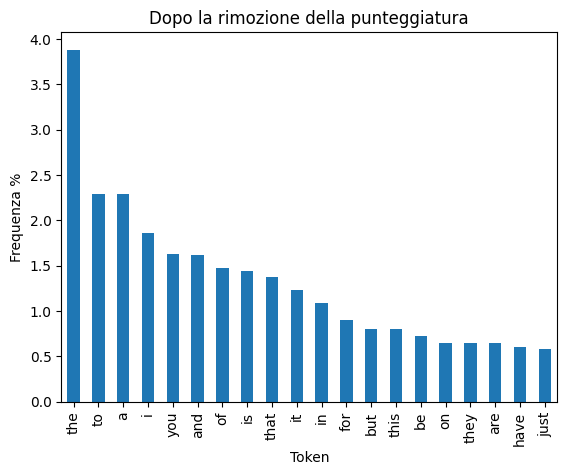

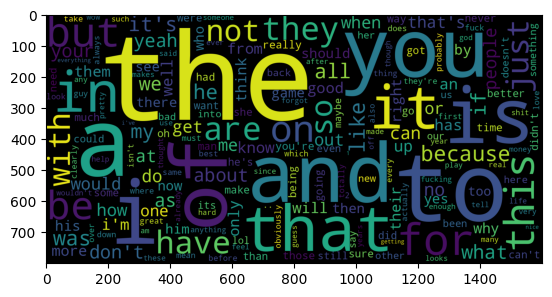

In [ ]:
outlier_punctuation = punctuation_freq.loc[abs(zscore(punctuation_freq['rateo'])) >= 3].index.values
print("I punti mantenuti sono:\t", outlier_punctuation)

# Rimozione
del_punctuation = [point for point in list(all_punctuation) if point not in outlier_punctuation]
df_train['text_tokenized'] = df_train['text_tokenized'].apply(
    lambda word_list: [word for word in word_list if word not in del_punctuation])
print_plot_most_common_token(df_train['text_tokenized'], text_print="Dopo la rimozione della punteggiatura:",
                             title_plot="Dopo la rimozione della punteggiatura")
plt.show()

Si procede con l'elminazione delle stopwords


 Dopo la rimozione delle stopword: 
 like      0.00955
yeah      0.00705
people    0.00608
get       0.00578
would     0.00551
that's    0.00520
one       0.00508
know      0.00497
well      0.00489
i'm       0.00485
Name: text_nsw, dtype: float64 




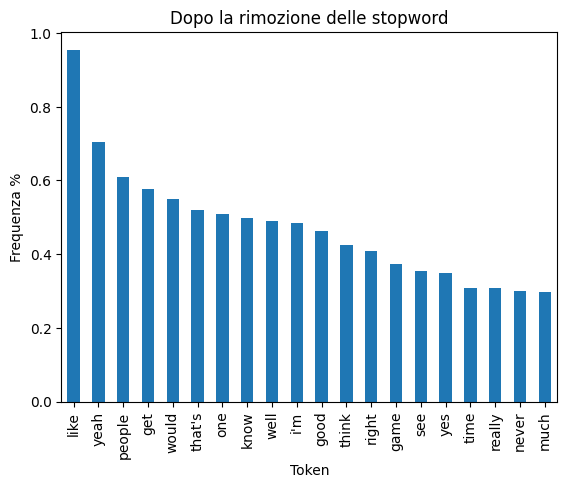

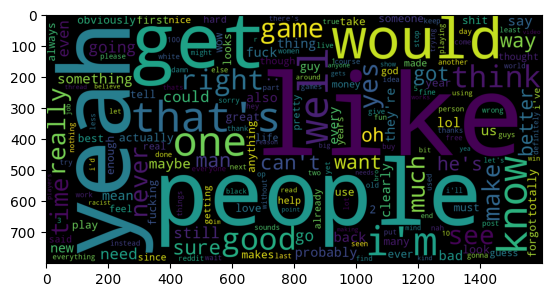

In [ ]:
df_train['text_nsw'] = df_train['text_tokenized'].apply(
    lambda word_list: [word for word in word_list if word not in stopwords.words('english')])
print_plot_most_common_token(df_train['text_nsw'], text_print="Dopo la rimozione delle stopword:",
                             title_plot="Dopo la rimozione delle stopword")
plt.show()

Si termina la fase con lo stemming


 Dopo la rimozione delle stopword e stemming: 
 lik       0.01005
get       0.00774
yeah      0.00705
us        0.00647
peopl     0.00628
know      0.00574
on        0.00558
would     0.00551
real      0.00524
that's    0.00520
Name: text_nsw_st, dtype: float64 



 Dopo lo stemming: 
 the     0.03898
a       0.02287
to      0.02287
i       0.01856
you     0.01631
and     0.01612
of      0.01471
is      0.01450
that    0.01423
it      0.01367
Name: text_st, dtype: float64 




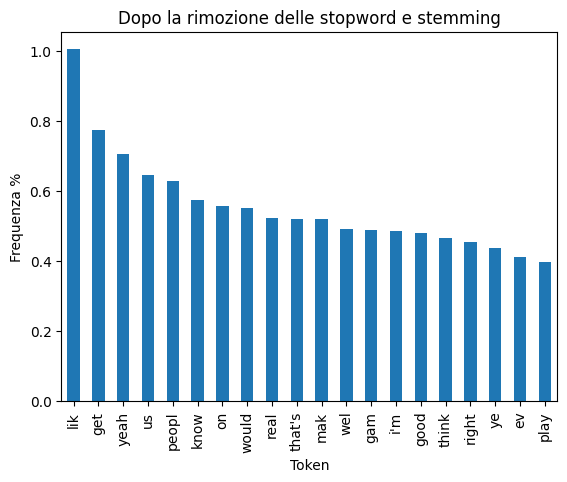

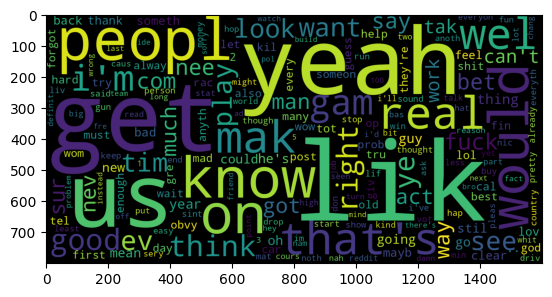

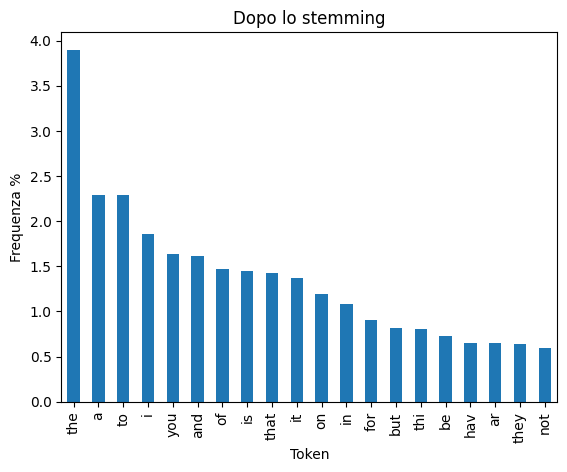

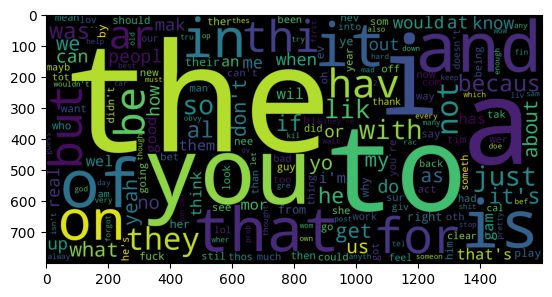

In [ ]:
# Stemming
stemmer = LancasterStemmer()
df_train['text_nsw_st'] = df_train['text_nsw'].apply(
    lambda word_list: [stemmer.stem(word) for word in word_list])
print_plot_most_common_token(df_train['text_nsw_st'], text_print="Dopo la rimozione delle stopword e stemming:",
                             title_plot="Dopo la rimozione delle stopword e stemming")

# Stemming con stopwords
df_train['text_st'] = df_train['text_tokenized'].apply(lambda word_list: [stemmer.stem(word) for word in word_list])
print_plot_most_common_token(df_train['text_st'], text_print="Dopo lo stemming:", title_plot="Dopo lo stemming")
plt.show()

## Confronto dei tipi di testo
In questa fase verranno confrontati i tre tipi di testi prodotti (nsw, nsw_st, st), in modo da individuare quale di essi porta più informazioni.


In [ ]:
def compute_helpful_words(text, target, vocabulary_size=1000, z_score=3):
    """
    Funzione che calcola le parole più utili per un modello, calcolando le proporzioni in cui compaiono sarcastiche e
    non, per poi mantenere quelle che superano lo z score
    :param text: serie contente il testo da elaborare (sotto forma di lista di token)
    :type text: pd.Series
    :param target: serie del target che (avendo lo stesso indice di text) fornisce la label
    :type target: pd.Series
    :param vocabulary_size: numero di feature-parole da estrarre
    :type vocabulary_size: int or None
    :param z_score: precisione di esclusione
    :type z_score: float
    :return: dataframe che ha come indice le parole, e come valori le loro proporzioni
    :rtype: pd.DataFrame
    """
    text_vectorizer = CountVectorizer(max_features=vocabulary_size)
    text = text.apply(lambda words_list: " ".join(words_list))

    text_vectorized = text_vectorizer.fit_transform(text)
    target = target.to_frame(TARGET)
    target['sparse_index'] = np.arange(len(target))

    index_s = target.loc[target[TARGET] == 1, 'sparse_index']
    index_ns = target.loc[target[TARGET] == 0, 'sparse_index']
    text_vectorized_s, text_vectorized_ns = text_vectorized[index_s.values] > 0, text_vectorized[index_ns.values] > 0

    text_s_prop = pd.DataFrame(index=text_vectorizer.get_feature_names_out(), columns=['sarcastic', 'not_sarcastic'])
    text_s_prop['sarcastic'] = np.array(text_vectorized_s.sum(axis=0))[0] / len(index_s)
    text_s_prop['not_sarcastic'] = np.array(text_vectorized_ns.sum(axis=0))[0] / len(index_ns)
    text_s_prop['rate'] = text_s_prop['sarcastic'] / (text_s_prop['sarcastic'] + text_s_prop['not_sarcastic'])
    text_s_prop['tot_occ'] = (text_s_prop['sarcastic'] * len(index_s) +
                              text_s_prop['not_sarcastic'] * len(index_ns))

    # elimino le parole che occorrono poco
    text_s_prop = text_s_prop.loc[text_s_prop['tot_occ'] > text_s_prop['tot_occ'].quantile(0.3)]

    return text_s_prop.loc[abs(zscore(text_s_prop['rate'])) >= z_score].sort_values(by='rate', ascending=False)

In [ ]:
precision = 2
vocab_size = None

nsw_hw = compute_helpful_words(df_train['text_nsw'], df_train[TARGET], vocabulary_size=vocab_size, z_score=precision)
nsw_st_hw = compute_helpful_words(df_train['text_nsw_st'], df_train[TARGET], vocabulary_size=vocab_size,
                                  z_score=precision)
st_hw = compute_helpful_words(df_train['text_st'], df_train[TARGET], vocabulary_size=vocab_size, z_score=precision)

print("nsw:\n", nsw_hw, "\n\nnsw_st:\n", nsw_st_hw, "\n\nst:\n", st_hw)
print("\n\nIl migliore è:\t",
      pd.Series(index=['nsw', 'nsw_st', 'st'], data=[len(text) for text in [nsw_hw, nsw_st_hw, st_hw]]
                ).sort_values(ascending=False))

nsw:
 Empty DataFrame
Columns: [sarcastic, not_sarcastic, rate, tot_occ]
Index: [] 

nsw_st:
 Empty DataFrame
Columns: [sarcastic, not_sarcastic, rate, tot_occ]
Index: [] 

st:
 Empty DataFrame
Columns: [sarcastic, not_sarcastic, rate, tot_occ]
Index: []


Il migliore è:	 nsw       0
nsw_st    0
st        0
dtype: int64


Vista l'uguaglianza dei tre, si decide di usare il testo senza stopwords e stemming (in quanto di dimensione ridotta)


In [ ]:
df_train = df_train.drop(columns=['text', 'text_tokenized', 'text_nsw', 'text_st']
                         ).rename(columns={'text_nsw_st': 'text'})

## Fase di preprocessing finale
In questa fase avviene il preprocessing finale prima del modello:
- Si elabora il testo parent come il testo del commento
- Si calcola la lunghezza delle frasi per il parent e per il testo
- Si preparano i dati del set di validation (usando i principi estratti dal train set)

In [ ]:
def text_processing(text, punctuation, join_str=None):
    """
    Funzione che riapplica gli step di processing del testo, secondo la pipeline già eseguita
    :param text: serie contenente il testo
    :type text: pd.Series
    :param punctuation: punti da eliminare
    :type punctuation: list
    :param join_str: stringa usata per effettuare l0unione dei token (riconvertendo il testo da lista a stringa)
    :type join_str: str
    :return: serie del testo rielaborata
    :rtype: pd.Series
    """

    tokenizer = TweetTokenizer()  # Tokenization
    tokenized = text.apply(lambda x: tokenizer.tokenize(x))

    # eliminazione della punteggiatura
    tokenized = tokenized.apply(lambda word_list: [word for word in word_list if word not in punctuation])

    # eliminazione delle stopwords
    nsw = tokenized.apply(lambda word_list: [word for word in word_list if word not in stopwords.words('english')])

    stem = LancasterStemmer()
    nsw_st = nsw.apply(lambda word_list: [stem.stem(word) for word in word_list])

    if join_str is not None:
        nsw_st = nsw_st.apply(lambda words_list: join_str.join(words_list))

    return nsw_st


def dataset_processing(dataframe, punctuation):
    """
    Funzione che elabora il dataset per essere usato dal modello
    :param dataframe: dataframe d'input
    :type dataframe: pd.DataFrame
    :param punctuation: punti da eliminare
    :type punctuation: list
    :return: dataframe rielaborato
    :rtype: pd.DataFrame
    """
    dataframe = dataset_opening_preprocessing(dataframe)
    dataframe['text'] = text_processing(dataframe['text'], punctuation, join_str=" <> ")
    dataframe['parent'] = text_processing(dataframe['parent'], punctuation, join_str=" <> ")
    return dataframe


def max_sentence_len(text):
    """
    Funzione che restituisce la lunghezza massima delle sentenze
    il valore massimo viene calcolato eliminando le sentenze troppo lunghe (quelle outliers, trovate tramite l'IQR)
    :param text: testo d'input
    :type text: pd.Series
    :return: lunghezza massima
    :rtype: int
    """
    text_s_len = text.apply(len)
    q1, q3 = text_s_len.quantile(0.25), text_s_len.quantile(0.75)
    return round(2 * (q3 + 1.5 * (q3 - q1)))

In [ ]:
df_train['parent'] = text_processing(df_train['parent'], del_punctuation)  # Processo il parent come il testo normale

# Calcolo il numero di token massimo nella distribuzione di testo e parent (parametro utilizzato dal modello)
text_len = max_sentence_len(df_train['text'])
parent_len = max_sentence_len(df_train['parent'])

print("lunghezza massima testo: ", text_len)
print("lunghezza massima parent: ", parent_len)

# Preparo i dati di train per il modello
df_train['text'] = df_train['text'].apply(lambda words_list: " <> ".join(words_list))
df_train['parent'] = df_train['parent'].apply(lambda words_list: " <> ".join(words_list))
df_val = dataset_processing(df_val, del_punctuation)

lunghezza massima testo:  26
lunghezza massima parent:  63


## Fase di modellazione
In questa fase verrà definita e addestrata la rete neurale adottata

In [ ]:
def custom_split(input_str):
    return tensorflow.strings.split(input_str, sep=" <> ")


def create_embedding_matrix(glove_path, vocab, embedding_dim, stemming=True):
    """
    Funzione che crea la embedding matrix a <embedding_dim> usando un GloVe Pretrained Embedding
    :param glove_path: path al glove file
    :type glove_path: str
    :param vocab: dizionario contenente i termini usati
    :type vocab: dict
    :param embedding_dim: dimensione di embedding (deve essere compatibile con il file)
    :type embedding_dim: int
    :param stemming: indica se effettuare lo stemming delle parole
    :type stemming: bool
    :return: embedding matrix risultante
    :rtype: np.matrix
    """
    stemmer = LancasterStemmer()
    word_index = dict(zip(vocab, range(len(vocab))))
    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    with open(glove_path, encoding="utf8") as glove_f:
        for line in glove_f:
            word, *vector = line.split()
            if stemming:
                word = stemmer.stem(word)
            if word in word_index.keys():
                embedding_matrix[word_index[word]] = np.array(vector, dtype='float32')

    return embedding_matrix

parent_len = 10
text_len = 10

Definizione dei layer di encoding 

delle features
Vengono definiti per primi in quanto devono adattarsi ale feature del training set.

In [ ]:
text_vectorize_layer = layers.TextVectorization(
    max_tokens=10000,
    standardize=None,
    split=custom_split,
    output_mode='int',
    output_sequence_length=text_len,
    name="text.split__int_encoding"
)
text_vectorize_layer.adapt(df_train['text'])
text_vocab = text_vectorize_layer.get_vocabulary()

parent_vectorize_layer = layers.TextVectorization(
    max_tokens=10000,
    standardize=None,
    split=custom_split,
    output_mode='int',
    output_sequence_length=parent_len,
    name="parent.split__int_encoding"
)
parent_vectorize_layer.adapt(df_train['parent'])
parent_vocab = parent_vectorize_layer.get_vocabulary()

author_vectorize_layer = layers.TextVectorization(
    max_tokens=10000,
    standardize=None,
    split=None,
    output_mode='multi_hot',
    name="author.hot_encoding__vs-10000"
)
author_vectorize_layer.adapt(df_train['author'])

subreddit_vectorize_layer = layers.TextVectorization(
    max_tokens=1000,
    standardize=None,
    split=None,
    output_mode='multi_hot',
    name="subreddit.hot_encoding__vs-1000"
)
subreddit_vectorize_layer.adapt(df_train['subreddit'])

Definizione dei layer d'input e connessione con gli encoder

In [ ]:
text_input = layers.Input(shape=(1,), name='text', dtype=tensorflow.string)
parent_input = layers.Input(shape=(1,), name='parent', dtype=tensorflow.string)
author_input = layers.Input(shape=(1,), name='author', dtype=tensorflow.string)
subreddit_input = layers.Input(shape=(1,), name='subreddit', dtype=tensorflow.string)

text_layers = text_vectorize_layer(text_input)
parent_layers = parent_vectorize_layer(parent_input)
author_layers = author_vectorize_layer(author_input)
subreddit_layers = subreddit_vectorize_layer(subreddit_input)

Definizione dei layer di emebedding (per il parent e il testo)

# ***SISTEMARE***

In [ ]:
# TODO: Rendere auto consistenti i file di glove
embedding_matrix_text = create_embedding_matrix(GLOVE_PATH, text_vocab, EMBEDDING_DIM)
embedding_matrix_parent = create_embedding_matrix(GLOVE_PATH, parent_vocab, EMBEDDING_DIM)

text_score = np.count_nonzero(np.count_nonzero(embedding_matrix_text, axis=1)) / len(text_vocab)
parent_score = np.count_nonzero(np.count_nonzero(embedding_matrix_parent, axis=1)) / len(parent_vocab)


print("L'Embedding matrix per il testo è completa al ", round(text_score, 2) * 100, "%")
print("L'Embedding matrix per il parent è completa al ", round(parent_score, 2) * 100, "%")


text_layers = layers.Embedding(output_dim=EMBEDDING_DIM,
                               input_length=text_len,
                               input_dim=len(text_vocab),
                               mask_zero=True,
                               embeddings_initializer=initializers.Constant(embedding_matrix_text),
                               trainable=False,
                               name="text.glove_embedding"
                               )(text_layers)
parent_layers = layers.Embedding(output_dim=EMBEDDING_DIM,
                                 input_length=parent_len,
                                 input_dim=len(parent_vocab),
                                 mask_zero=True,
                                 embeddings_initializer=initializers.Constant(embedding_matrix_parent),
                                 trainable=False,
                                 name="parent.glove_embedding"
                                 )(parent_layers)

L'Embedding matrix per il testo è completa al  93.0 %
L'Embedding matrix per il parent è completa al  91.0 %


Definizione dei layer di calcolo

In [ ]:
text_layers = layers.Bidirectional(layers.LSTM(50, return_sequences=True, name="lstm_tp1"),
                                   name="text.processing_1")(text_layers)
text_layers = layers.Bidirectional(layers.LSTM(10, return_sequences=False, name="lstm_tp2"),
                                   name="text.processing_2")(text_layers)

parent_layers = layers.Bidirectional(layers.LSTM(50, return_sequences=False, name="lstm_pp1"),
                                     name="parent.processing")(parent_layers)
author_layers = layers.Dense(100, name="author.processing__relu", activation=activations.relu)(author_layers)
subreddit_layers = layers.Dense(50, name="subreddit.processing__relu", activation=activations.relu)(subreddit_layers)


Concatenazione degli elementi del contesto

In [ ]:
contex_layers = layers.Concatenate(name="contex_concatenation")([parent_layers, author_layers, subreddit_layers])
contex_layers = layers.Dense(10, name="contex.processing__relu", activation=activations.relu)(contex_layers)

Concatenazione del contesto col testo e aggiunta del layer di output

In [ ]:
global_layers = layers.Concatenate(name="global_concatenation")([text_layers, contex_layers])
global_layers = layers.Dense(10, name="global.processing__relu", activation=activations.relu)(global_layers)

output = layers.Dense(1, activation=activations.sigmoid, name="output")(global_layers)

Creazione e addestramento del modello

In [ ]:
EPOCHS = 30
model = models.Model(inputs=[text_input, parent_input, author_input, subreddit_input], outputs=output)
model.compile(optimizer="adam", loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy()])

model.summary()
utils.plot_model(model, to_file="model_final.png", show_shapes=True)

history = model.fit(x=[df_train['text'], df_train['parent'], df_train['author'], df_train['subreddit']],
                    y=df_train[TARGET],
                    validation_data=([df_val['text'], df_val['parent'], df_val['author'], df_val['subreddit']],
                                     df_val[TARGET]),
                    batch_size=128, epochs=EPOCHS, verbose=1,
                    callbacks=callbacks.EarlyStopping(monitor='val_loss', patience=int(EPOCHS/3),
                                                      restore_best_weights=True))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 parent (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 parent.split__int_encoding (Te  (None, 10)          0           ['parent[0][0]']                 
 xtVectorization)                                                                                 
                                                                                                  
 author (InputLayer)            [(None, 1)]          0           []                         

Plotting dell'history del modello

In [ ]:
history = pd.DataFrame(data=history)
history.index.name = 'epochs'

history.plot(title="History di training")
plt.show()

ValueError: ignored

Try

In [ ]:
compare_df = df_val[TARGET].to_frame(name="real")
compare_df['predicted'] = np.round(model.predict([df_val['text'], df_val['parent'],
                                                  df_val['author'], df_val['subreddit']])).astype(int)

In [ ]:
print(compare_df)
from sklearn.metrics import classification_report
print(classification_report(compare_df['real'], compare_df['predicted'], target_names=['sarcastic', 'not sarcastic']))

from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
conf_matrix = confusion_matrix(compare_df['real'], compare_df['predicted'])
print(conf_matrix)

PrecisionRecallDisplay.from_predictions(compare_df['real'], compare_df['predicted']).plot()

import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, ax=ax)